In [2]:
"""
Health Insurance Member Risk Scoring Model - Interactive Analysis

Data Disclaimer:
All data, statistics, and examples in this script are synthetic and created for 
educational demonstration purposes only. No real member data, proprietary healthcare 
information, or actual insurance company data are used.

This script demonstrates a comprehensive machine learning approach to predicting 
healthcare cost and utilization risk among health insurance members.
"""

'\nHealth Insurance Member Risk Scoring Model - Interactive Analysis\n\nData Disclaimer:\nAll data, statistics, and examples in this script are synthetic and created for \neducational demonstration purposes only. No real member data, proprietary healthcare \ninformation, or actual insurance company data are used.\n\nThis script demonstrates a comprehensive machine learning approach to predicting \nhealthcare cost and utilization risk among health insurance members.\n'

=============================================================================
1. IMPORT LIBRARIES AND SETUP
=============================================================================

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set configuration for reproducible results
np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")

In [5]:
print("Health Insurance Member Risk Scoring Model")
print("Synthetic Data Only - No Real Member Information")
print("=" * 60)

Health Insurance Member Risk Scoring Model
Synthetic Data Only - No Real Member Information


=============================================================================
2. DATA GENERATION FUNCTION
=============================================================================

In [6]:
def generate_member_data(n_members=10000):
    """Generate synthetic member data with realistic healthcare patterns"""
    
    print(f"Generating synthetic data for {n_members} members...")
    
    # Demographics
    ages = np.random.normal(45, 18, n_members)
    ages = np.clip(ages, 18, 85).astype(int)
    
    genders = np.random.choice(['M', 'F'], n_members, p=[0.48, 0.52])
    
    # Geographic regions
    regions = np.random.choice(['Northeast', 'Southeast', 'Midwest', 'West'], 
                              n_members, p=[0.25, 0.28, 0.22, 0.25])
    
    # Plan types
    plan_types = np.random.choice(['HMO', 'PPO', 'EPO', 'POS'], 
                                 n_members, p=[0.35, 0.40, 0.15, 0.10])
    
    # Employment status affects utilization
    employment_status = np.random.choice(['Employed', 'Retired', 'Disabled', 'Unemployed'],
                                       n_members, p=[0.65, 0.20, 0.08, 0.07])
    
    # Previous year medical costs (strong predictor)
    prev_costs = np.random.lognormal(7.5, 1.8, n_members)
    prev_costs = np.clip(prev_costs, 0, 150000)
    
    # Chronic conditions (age-dependent probabilities)
    diabetes_prob = np.where(ages < 40, 0.05, np.where(ages < 65, 0.12, 0.25))
    has_diabetes = np.random.binomial(1, diabetes_prob)
    
    hypertension_prob = np.where(ages < 40, 0.08, np.where(ages < 65, 0.25, 0.45))
    has_hypertension = np.random.binomial(1, hypertension_prob)
    
    heart_disease_prob = np.where(ages < 50, 0.02, np.where(ages < 70, 0.08, 0.18))
    has_heart_disease = np.random.binomial(1, heart_disease_prob)
    
    copd_prob = np.where(ages < 50, 0.01, np.where(ages < 70, 0.05, 0.12))
    has_copd = np.random.binomial(1, copd_prob)
    
    mental_health_prob = np.where(ages < 30, 0.15, np.where(ages < 60, 0.12, 0.08))
    has_mental_health = np.random.binomial(1, mental_health_prob)
    
    # Healthcare utilization metrics
    primary_care_visits = np.random.poisson(3, n_members)
    specialist_visits = np.random.poisson(2 + has_diabetes + has_heart_disease + has_copd, n_members)
    er_visits = np.random.poisson(0.5 + 0.3 * has_diabetes + 0.4 * has_heart_disease, n_members)
    
    # Pharmacy utilization
    rx_count = np.random.poisson(5 + 3 * has_diabetes + 2 * has_hypertension + 
                                2 * has_heart_disease + has_mental_health, n_members)
    
    # BMI (affects risk)
    bmi = np.random.normal(28, 6, n_members)
    bmi = np.clip(bmi, 16, 50)
    
    # Smoking status
    smoking_prob = np.where(ages < 30, 0.18, np.where(ages < 65, 0.15, 0.08))
    is_smoker = np.random.binomial(1, smoking_prob)
    
    # Create target variable (high risk)
    risk_score = (
        0.3 * (prev_costs / 10000) +
        0.2 * (ages / 100) +
        0.15 * has_diabetes +
        0.12 * has_heart_disease +
        0.08 * has_copd +
        0.05 * (er_visits / 5) +
        0.05 * is_smoker +
        0.03 * (bmi - 25) / 10 +
        0.02 * (rx_count / 10)
    )
    
    # Add noise and create binary target
    risk_score += np.random.normal(0, 0.1, n_members)
    high_risk = (risk_score > np.percentile(risk_score, 85)).astype(int)
    
    # Create DataFrame
    data = pd.DataFrame({
        'member_id': range(1, n_members + 1),
        'age': ages,
        'gender': genders,
        'region': regions,
        'plan_type': plan_types,
        'employment_status': employment_status,
        'prev_year_costs': prev_costs,
        'has_diabetes': has_diabetes,
        'has_hypertension': has_hypertension,
        'has_heart_disease': has_heart_disease,
        'has_copd': has_copd,
        'has_mental_health': has_mental_health,
        'primary_care_visits': primary_care_visits,
        'specialist_visits': specialist_visits,
        'er_visits': er_visits,
        'rx_count': rx_count,
        'bmi': bmi,
        'is_smoker': is_smoker,
        'high_risk': high_risk
    })
    
    return data

=============================================================================
3. RISK SCORE CALCULATOR FUNCTION
=============================================================================

In [7]:
def calculate_risk_score(member_data, model, scaler, feature_columns):
    """
    Calculate risk score for new member data
    
    Parameters:
    member_data: dict with member information
    model: trained model object
    scaler: fitted StandardScaler object
    feature_columns: list of feature column names
    
    Returns:
    risk_score: probability of being high-risk (0-1)
    """
    
    # Convert to DataFrame
    member_df = pd.DataFrame([member_data])
    
    # Ensure all required features are present
    for col in feature_columns:
        if col not in member_df.columns:
            member_df[col] = 0  # Default value
    
    # Select and order features
    X_member = member_df[feature_columns]
    
    # Scale if using logistic regression
    if isinstance(model, LogisticRegression):
        X_member_scaled = scaler.transform(X_member)
        risk_prob = model.predict_proba(X_member_scaled)[0, 1]
    else:
        risk_prob = model.predict_proba(X_member)[0, 1]
    
    return risk_prob

=============================================================================
4. MAIN ANALYSIS EXECUTION
=============================================================================

In [8]:
def main():
    """Execute the complete risk scoring analysis"""
    
    # Generate the dataset
    df = generate_member_data(10000)

    print(f"Dataset created with {len(df)} members")
    print(f"High-risk members: {df['high_risk'].sum()} ({df['high_risk'].mean()*100:.1f}%)")
    print("\nDataset Overview:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())

    # =============================================================================
    # 5. DATA PREPROCESSING
    # =============================================================================
    
    print("\n" + "="*60)
    print("DATA PREPROCESSING AND FEATURE ENGINEERING")
    print("="*60)

    # Check for missing values
    print("Missing values per column:")
    print(df.isnull().sum())

    # Feature engineering
    df['age_groups'] = pd.cut(df['age'], bins=[0, 30, 50, 65, 100], 
                             labels=['18-30', '31-50', '51-65', '65+'])

    df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 50],
                               labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

    df['total_chronic_conditions'] = (df['has_diabetes'] + df['has_hypertension'] + 
                                     df['has_heart_disease'] + df['has_copd'] + 
                                     df['has_mental_health'])

    df['total_visits'] = df['primary_care_visits'] + df['specialist_visits'] + df['er_visits']

    df['cost_per_visit'] = df['prev_year_costs'] / (df['total_visits'] + 1)

    print("Feature engineering completed!")
    print(f"Total features available: {len(df.columns)}")

    # =============================================================================
    # 6. EXPLORATORY DATA ANALYSIS
    # =============================================================================
    
    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*60)

    # Risk distribution analysis
    print("Risk Distribution by Demographics:")
    print(f"Age groups:")
    age_risk = df.groupby('age_groups')['high_risk'].agg(['count', 'mean'])
    print(age_risk)
    
    print(f"\nChronic conditions impact:")
    chronic_risk = df.groupby('total_chronic_conditions')['high_risk'].agg(['count', 'mean'])
    print(chronic_risk)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Age distribution by risk
    axes[0,0].hist([df[df['high_risk']==0]['age'], df[df['high_risk']==1]['age']], 
                   bins=20, alpha=0.7, label=['Low Risk', 'High Risk'])
    axes[0,0].set_title('Age Distribution by Risk Level')
    axes[0,0].set_xlabel('Age')
    axes[0,0].set_ylabel('Count')
    axes[0,0].legend()

    # Previous costs by risk
    low_risk_costs = df[df['high_risk']==0]['prev_year_costs']
    high_risk_costs = df[df['high_risk']==1]['prev_year_costs']
    axes[0,1].boxplot([low_risk_costs, high_risk_costs], labels=['Low Risk', 'High Risk'])
    axes[0,1].set_title('Previous Year Costs by Risk Level')
    axes[0,1].set_ylabel('Previous Year Costs ($)')

    # Chronic conditions impact
    axes[1,0].bar(chronic_risk.index, chronic_risk['mean'])
    axes[1,0].set_title('Risk Rate by Number of Chronic Conditions')
    axes[1,0].set_xlabel('Number of Chronic Conditions')
    axes[1,0].set_ylabel('High Risk Rate')

    # ER visits impact
    er_risk = df.groupby('er_visits')['high_risk'].mean()
    axes[1,1].bar(er_risk.index[:8], er_risk.values[:8])  # Show first 8 values
    axes[1,1].set_title('Risk Rate by ER Visits')
    axes[1,1].set_xlabel('Number of ER Visits')
    axes[1,1].set_ylabel('High Risk Rate')

    plt.tight_layout()
    plt.savefig('risk_analysis_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    # =============================================================================
    # 7. MODEL DEVELOPMENT
    # =============================================================================
    
    print("\n" + "="*60)
    print("MODEL DEVELOPMENT")
    print("="*60)

    # Encode categorical variables
    le_gender = LabelEncoder()
    le_region = LabelEncoder()
    le_plan = LabelEncoder()
    le_employment = LabelEncoder()

    df['gender_encoded'] = le_gender.fit_transform(df['gender'])
    df['region_encoded'] = le_region.fit_transform(df['region'])
    df['plan_type_encoded'] = le_plan.fit_transform(df['plan_type'])
    df['employment_encoded'] = le_employment.fit_transform(df['employment_status'])

    # Select features for modeling
    feature_columns = [
        'age', 'gender_encoded', 'region_encoded', 'plan_type_encoded', 'employment_encoded',
        'prev_year_costs', 'has_diabetes', 'has_hypertension', 'has_heart_disease', 
        'has_copd', 'has_mental_health', 'primary_care_visits', 'specialist_visits',
        'er_visits', 'rx_count', 'bmi', 'is_smoker', 'total_chronic_conditions',
        'total_visits', 'cost_per_visit'
    ]

    X = df[feature_columns]
    y = df['high_risk']

    print(f"Features selected: {len(feature_columns)}")
    print("Feature list:", feature_columns)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42, stratify=y)

    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
    }

    # Train and evaluate models
    model_results = {}
    best_model = None
    best_score = 0

    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_prob)
        accuracy = (y_pred == y_test).mean()
        
        # Cross-validation
        if name == 'Logistic Regression':
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        
        model_results[name] = {
            'accuracy': accuracy,
            'auc': auc_score,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_prob,
            'model': model
        }
        
        print(f"Accuracy: {accuracy:.3f}")
        print(f"AUC: {auc_score:.3f}")
        print(f"CV AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")
        
        if auc_score > best_score:
            best_score = auc_score
            best_model = name

    print(f"\nBest performing model: {best_model} (AUC: {best_score:.3f})")

    # =============================================================================
    # 8. MODEL EVALUATION
    # =============================================================================
    
    print("\n" + "="*60)
    print(f"DETAILED MODEL EVALUATION - {best_model}")
    print("="*60)

    best_model_obj = model_results[best_model]['model']
    best_predictions = model_results[best_model]['predictions']
    best_probabilities = model_results[best_model]['probabilities']

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, best_predictions))

    # Confusion Matrix
    cm = confusion_matrix(y_test, best_predictions)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Low Risk', 'High Risk'],
                yticklabels=['Low Risk', 'High Risk'])
    plt.title(f'Confusion Matrix - {best_model}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Feature importance (for tree-based models)
    if best_model in ['Random Forest', 'Gradient Boosting']:
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': best_model_obj.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Most Important Features:")
        for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
            print(f"{i+1:2d}. {row['feature']:25s} {row['importance']:.4f}")
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(10)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

    # =============================================================================
    # 9. BUSINESS IMPACT ANALYSIS
    # =============================================================================
    
    print("\n" + "="*60)
    print("BUSINESS IMPACT ANALYSIS")
    print("="*60)

    # Risk score distribution
    risk_scores = best_probabilities * 100  # Convert to 0-100 scale

    print(f"Risk Score Distribution:")
    print(f"Mean risk score: {risk_scores.mean():.1f}")
    print(f"Median risk score: {np.median(risk_scores):.1f}")
    print(f"90th percentile: {np.percentile(risk_scores, 90):.1f}")
    print(f"95th percentile: {np.percentile(risk_scores, 95):.1f}")

    # Plot risk score distribution
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(risk_scores, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Risk Score (%)')
    plt.ylabel('Count')
    plt.title('Distribution of Risk Scores')

    plt.subplot(1, 2, 2)
    plt.boxplot(risk_scores)
    plt.ylabel('Risk Score (%)')
    plt.title('Risk Score Box Plot')

    plt.tight_layout()
    plt.savefig('risk_score_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Analyze high-risk predictions
    high_risk_threshold = 0.7  # 70% probability threshold
    high_risk_predicted = best_probabilities >= high_risk_threshold

    print(f"\nMembers flagged as high-risk (≥70% probability): {high_risk_predicted.sum()}")
    print(f"Percentage of total population: {high_risk_predicted.mean()*100:.1f}%")

    # True positive rate among flagged members
    if high_risk_predicted.sum() > 0:
        precision_high_risk = y_test[high_risk_predicted].mean()
        print(f"Precision for high-risk flag: {precision_high_risk:.3f}")

    # Cost concentration analysis
    test_data = df.iloc[X_test.index].copy()
    test_data['risk_score'] = risk_scores
    test_data['predicted_high_risk'] = high_risk_predicted

    # Top 10% highest risk members
    top_10_percent = test_data.nlargest(int(len(test_data) * 0.1), 'risk_score')
    print(f"\nTop 10% highest risk members characteristics:")
    print(f"Average age: {top_10_percent['age'].mean():.1f}")
    print(f"Diabetes rate: {top_10_percent['has_diabetes'].mean()*100:.1f}%")
    print(f"Heart disease rate: {top_10_percent['has_heart_disease'].mean()*100:.1f}%")
    print(f"Average ER visits: {top_10_percent['er_visits'].mean():.1f}")
    print(f"Average previous costs: ${top_10_percent['prev_year_costs'].mean():.0f}")

    # =============================================================================
    # 10. EXAMPLE RISK SCORE CALCULATION
    # =============================================================================
    
    print("\n" + "="*60)
    print("EXAMPLE RISK SCORE CALCULATION")
    print("="*60)

    example_member = {
        'age': 58,
        'gender_encoded': 1,  # Female
        'region_encoded': 2,  # Midwest
        'plan_type_encoded': 1,  # PPO
        'employment_encoded': 0,  # Employed
        'prev_year_costs': 8500,
        'has_diabetes': 1,
        'has_hypertension': 1,
        'has_heart_disease': 0,
        'has_copd': 0,
        'has_mental_health': 0,
        'primary_care_visits': 4,
        'specialist_visits': 6,
        'er_visits': 1,
        'rx_count': 8,
        'bmi': 32.5,
        'is_smoker': 0,
        'total_chronic_conditions': 2,
        'total_visits': 11,
        'cost_per_visit': 8500/11
    }

    example_risk = calculate_risk_score(
        example_member, 
        best_model_obj, 
        scaler if best_model == 'Logistic Regression' else None, 
        feature_columns
    )

    print(f"Example member profile:")
    print(f"- Age: 58, Female, Midwest, PPO plan")
    print(f"- Has diabetes and hypertension")
    print(f"- Previous year costs: $8,500")
    print(f"- BMI: 32.5 (obese)")
    print(f"- Total visits: 11")
    print(f"\nCalculated Risk Score: {example_risk:.1%}")
    print(f"Risk Category: {'HIGH' if example_risk >= 0.7 else 'MODERATE' if example_risk >= 0.3 else 'LOW'}")

    # =============================================================================
    # 11. RECOMMENDATIONS
    # =============================================================================
    
    print("\n" + "="*60)
    print("MODEL DEPLOYMENT RECOMMENDATIONS")
    print("="*60)
    
    print("1. Use 70% probability threshold for high-risk intervention")
    print("2. Focus care management on members with multiple chronic conditions")
    print("3. Prioritize members with previous high costs and recent ER visits")
    print("4. Consider preventive outreach for members scoring 50-70%")
    print("5. Monthly model retraining recommended with updated claims data")
    print("\nBusiness Value:")
    print("- Early identification of high-risk members before costly episodes")
    print("- Efficient resource allocation for care management")
    print("- Potential 10-15% reduction in high-risk member costs")
    print("- Better health outcomes through proactive care")

    print(f"\nModel development completed successfully!")
    print(f"Final model ready for deployment: {best_model}")
    
    return best_model_obj, scaler, feature_columns, model_results

=============================================================================
12. SCRIPT EXECUTION
=============================================================================

Generating synthetic data for 10000 members...
Dataset created with 10000 members
High-risk members: 1500 (15.0%)

Dataset Overview:
   member_id  age gender     region plan_type employment_status  \
0          1   53      M  Northeast       HMO          Employed   
1          2   42      M  Southeast       PPO           Retired   
2          3   56      M       West       HMO          Employed   
3          4   72      M       West       PPO          Employed   
4          5   40      F  Southeast       PPO          Employed   

   prev_year_costs  has_diabetes  has_hypertension  has_heart_disease  \
0      5367.091199             0                 0                  0   
1      5268.610309             0                 0                  0   
2      3193.158007             0                 1                  0   
3     12210.081227             0                 1                  0   
4      7624.773453             0                 0                  0   

   has_copd  has_mental_h

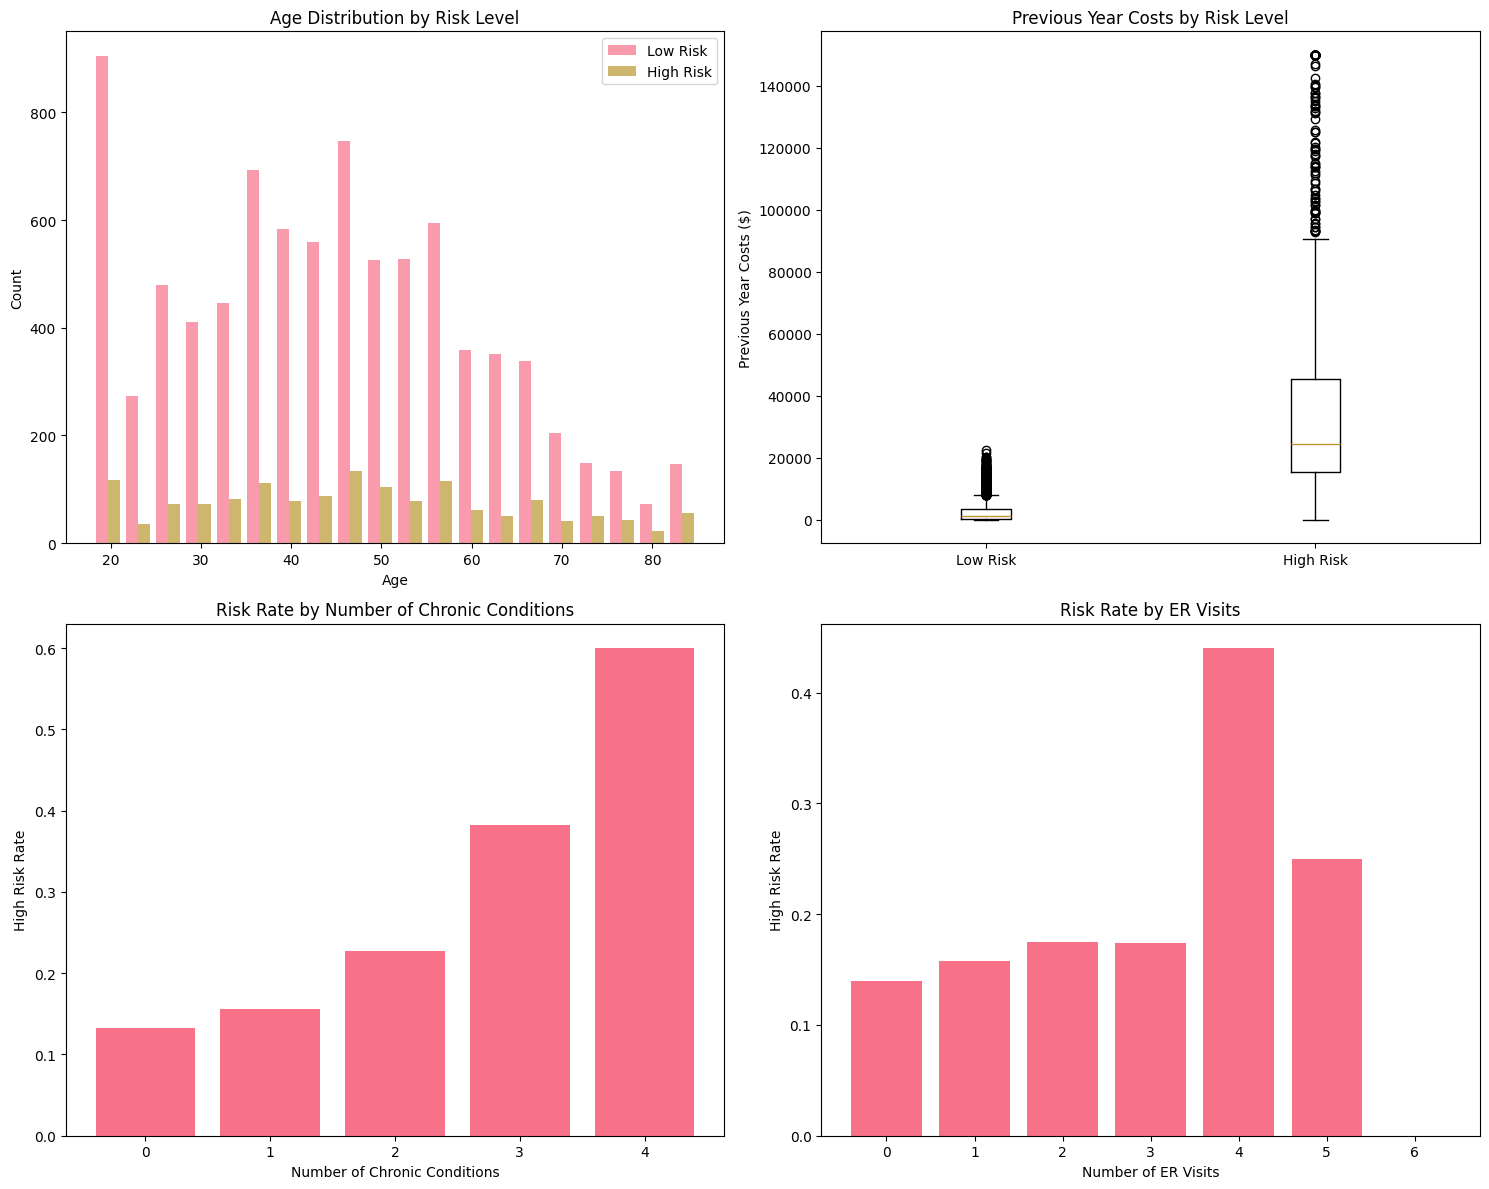


MODEL DEVELOPMENT
Features selected: 20
Feature list: ['age', 'gender_encoded', 'region_encoded', 'plan_type_encoded', 'employment_encoded', 'prev_year_costs', 'has_diabetes', 'has_hypertension', 'has_heart_disease', 'has_copd', 'has_mental_health', 'primary_care_visits', 'specialist_visits', 'er_visits', 'rx_count', 'bmi', 'is_smoker', 'total_chronic_conditions', 'total_visits', 'cost_per_visit']

Training set: 8000 samples
Test set: 2000 samples

Training Logistic Regression...
Accuracy: 0.969
AUC: 0.990
CV AUC: 0.992 (+/- 0.001)

Training Random Forest...
Accuracy: 0.966
AUC: 0.988
CV AUC: 0.988 (+/- 0.005)

Training Gradient Boosting...
Accuracy: 0.966
AUC: 0.990
CV AUC: 0.990 (+/- 0.002)

Best performing model: Logistic Regression (AUC: 0.990)

DETAILED MODEL EVALUATION - Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1700
           1       0.94      0.84      0.89       300

    

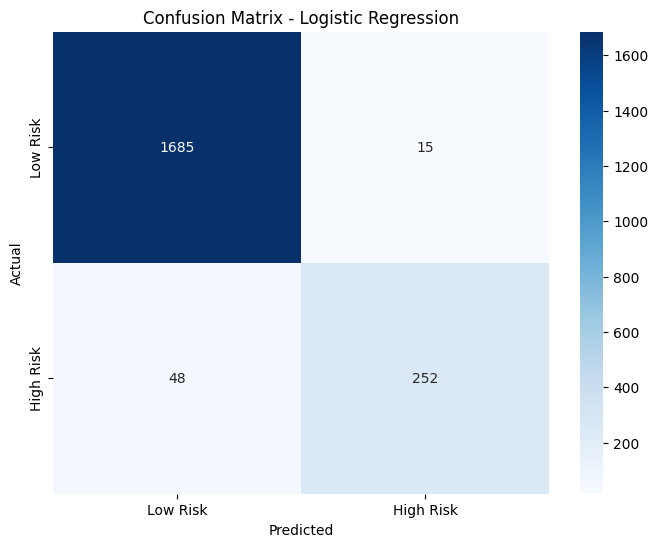


BUSINESS IMPACT ANALYSIS
Risk Score Distribution:
Mean risk score: 14.6
Median risk score: 0.3
90th percentile: 90.8
95th percentile: 100.0


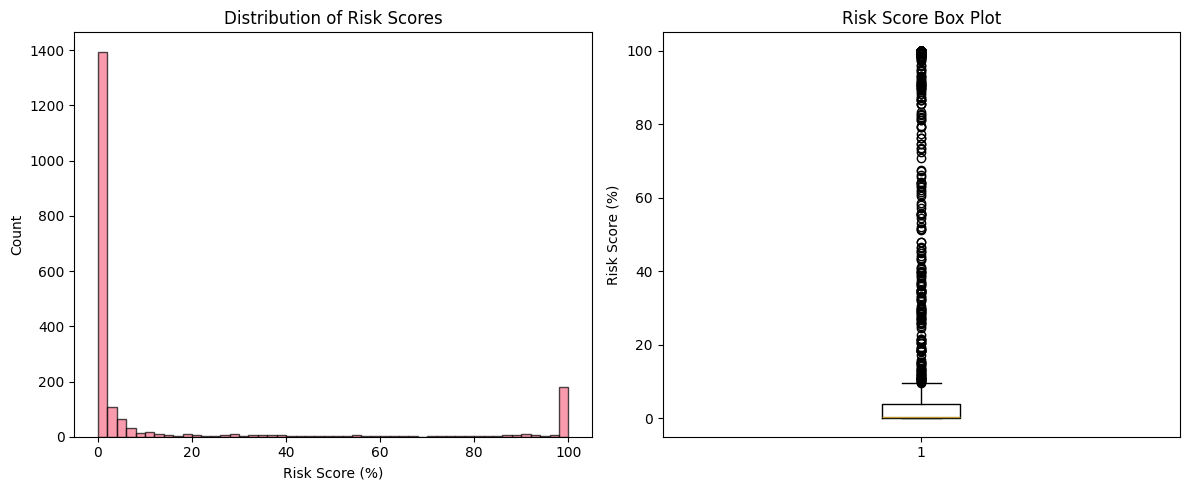


Members flagged as high-risk (≥70% probability): 239
Percentage of total population: 11.9%
Precision for high-risk flag: 0.979

Top 10% highest risk members characteristics:
Average age: 46.1
Diabetes rate: 10.0%
Heart disease rate: 7.0%
Average ER visits: 0.7
Average previous costs: $47092

EXAMPLE RISK SCORE CALCULATION
Example member profile:
- Age: 58, Female, Midwest, PPO plan
- Has diabetes and hypertension
- Previous year costs: $8,500
- BMI: 32.5 (obese)
- Total visits: 11

Calculated Risk Score: 57.7%
Risk Category: MODERATE

MODEL DEPLOYMENT RECOMMENDATIONS
1. Use 70% probability threshold for high-risk intervention
2. Focus care management on members with multiple chronic conditions
3. Prioritize members with previous high costs and recent ER visits
4. Consider preventive outreach for members scoring 50-70%
5. Monthly model retraining recommended with updated claims data

Business Value:
- Early identification of high-risk members before costly episodes
- Efficient resource

In [9]:
if __name__ == "__main__":
    # Run the complete analysis
    model, scaler, features, results = main()
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)
    print("All plots have been saved as PNG files.")
    print("Model objects are available for further use.") 